In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input,Reshape
import glob
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import cv2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import numpy as np

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available.")

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
pretrained_model = tf.keras.applications.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = True


In [ ]:
# Flatten the output of the pretrained model
flatten_layer = Flatten()(pretrained_model.output)

# Add a dense layer with 9 units (3x3 matrix)
dense_layer = Dense(9, activation='relu')(flatten_layer)

# Reshape the output to be a 3x3 matrix
output_layer = Reshape((3, 3))(dense_layer)


In [ ]:
input_layer = pretrained_model.input
model = Model(inputs=input_layer, outputs=output_layer, )

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
DATA_DIR = "/home/fer/Escritorio/futstatistics/datasets/dataset7_homography"


images_1 = glob.glob(os.path.join(DATA_DIR, "test") + "/*.jpg")
images_2 = glob.glob(os.path.join(DATA_DIR, "train_val") + "/*.jpg")

labels_1 = glob.glob(os.path.join(DATA_DIR, "test") + "/*.homographyMatrix")
labels_2 = glob.glob(os.path.join(DATA_DIR, "train_val") + "/*.homographyMatrix")

images = sorted(images_1 + images_2)
labels = sorted(labels_1 + labels_2)

print(len(images))
print(len(labels))

In [ ]:
# Define your batch size and number of epochs
batch_size = 4
epochs = 100

In [16]:

def read_homography(file_path):
    # Initialize an empty list to store the matrix data
    homography_matrix = []

    # Open the file and read its contents line by line
    with open(file_path, 'r') as file:
        for line in file:
            # Split each line into individual elements (assuming space-separated values)
            elements = line.strip().split()
            
            # Convert the elements to float and append them to the matrix
            row = [float(element) for element in elements]
            homography_matrix.append(row)

    # Convert the list of lists to a NumPy array
    return np.array(homography_matrix)


In [ ]:
def data_generator(images, matrices, batch_size):
    num_samples = len(images)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_images = [preprocess_input(
                cv2.resize( cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB) , (224,224))
               ) for i in batch_indices]
            batch_matrices = [read_homography(matrices[i]).reshape(3, 3) for i in batch_indices]
            
            # Preprocess your images and matrices here as needed
            
            yield np.array(batch_images), np.array(batch_matrices)


In [ ]:
train_images,val_images,train_matrices,val_matrices = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    "./homography_checkpoints/best_ckpt.hdf5",
    monitor='val_loss',  # You can choose the metric to monitor
    save_best_only=True,  # Save only the best models
    save_weights_only=True,  # Save only the model weights
    mode='min',  # 'min' for loss minimization, 'max' for accuracy maximization
    verbose=1  # Display messages when checkpoints are saved
)

early_stopping = EarlyStopping(
            monitor="val_loss", patience=20
)

In [ ]:

# Create the data generator
train_generator = data_generator(train_images, train_matrices, batch_size)
validation_generator = data_generator(val_images, val_matrices, batch_size)


In [ ]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(val_images) // batch_size,
    callbacks = [checkpoint_callback,early_stopping]
)

# TEST

In [17]:
import matplotlib.pyplot as plt

In [26]:
DATA_DIR = "/home/fer/Escritorio/futstatistics/datasets/dataset7_homography"


images_1 = glob.glob(os.path.join(DATA_DIR, "test") + "/*.jpg")
images_2 = glob.glob(os.path.join(DATA_DIR, "train_val") + "/*.jpg")

labels_1 = glob.glob(os.path.join(DATA_DIR, "test") + "/*.homographyMatrix")
labels_2 = glob.glob(os.path.join(DATA_DIR, "train_val") + "/*.homographyMatrix")

gt_1 = glob.glob(os.path.join(DATA_DIR, "test") + "/*.mat")
gt_2 = glob.glob(os.path.join(DATA_DIR, "train_val") + "/*.mat")

images = sorted(images_1 + images_2)
labels = sorted(labels_1 + labels_2)
gt = sorted(gt_1 + gt_2)

print(len(images))
print(len(labels))
print(len(gt))

395
395
396


In [25]:
images[0]

'/home/fer/Escritorio/futstatistics/datasets/dataset7_homography/test/1.jpg'

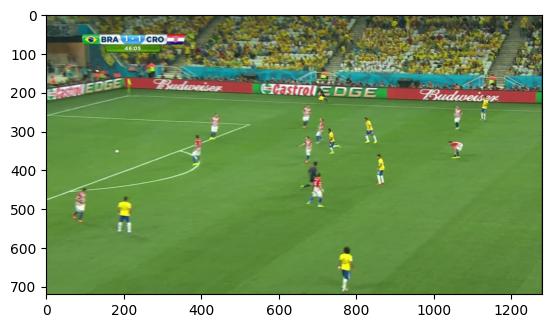

In [21]:
im = cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB)
field = cv2.cvtColor(cv2.imread("field_2d.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [29]:
import scipy

In [33]:
mat = scipy.io.loadmat(gt[0])
print(mat['grass'].shape)

(720, 1280)


In [34]:
homo = read_homography(labels[0])
print(homo)

[[ 9.1842785e-02  3.6737114e-01 -9.6902522e+01]
 [-2.8247420e-02  7.3986511e-01 -1.4981605e+02]
 [ 1.8463391e-04  7.1046551e-03  1.0000000e+00]]


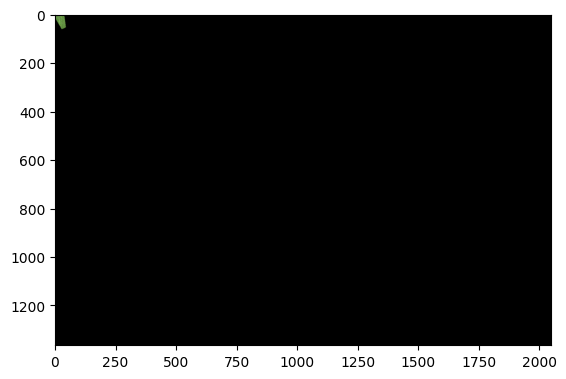

In [35]:
warped = cv2.warpPerspective(im, homo, (field.shape[1], field.shape[0]))
plt.imshow(warped)

In [46]:
POINT = (200,300)
POINT_ = np.array([POINT],np.float32).reshape(-1,1,2)
POINT_2D = cv2.perspectiveTransform(POINT_, homo).astype(int)

In [48]:
tuple(POINT_2D[0][0])

(9, 20)

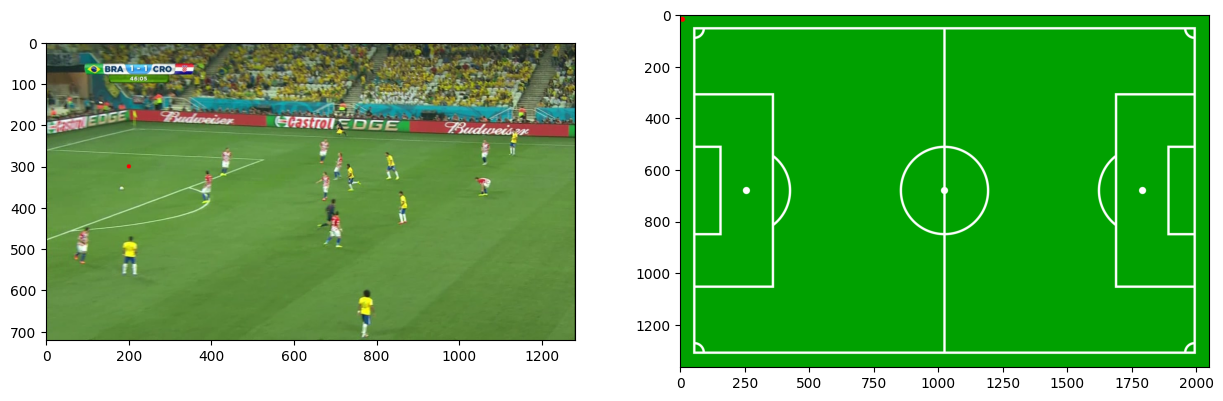

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

im  = cv2.circle(im,POINT,  5, (255, 0, 0), -1)
field  = cv2.circle(field,tuple(POINT_2D[0][0]),  10, (255, 0, 0), -1)


ax[0].imshow(im)
ax[1].imshow(field)